## Jupyter Kernel for Rust Programming Language

[evcxr] is an evaluation context for Rust. It is an unofficial google project that offers several related crates, one of which is [evcxr_jupyter] which is a Juypter Kernel for the Rust programming language.

BTW, if you're wondering how to pronounce `EvCxR`; it's pronounced *"Evic-ser"* cos it's an **EV**aluation Conte**X**t for **R**ust.

You can take a [tour of the Juypter Kernel][tour] to get a feel for using Rust in Jupyter Notebooks.

## Setup

You can setup `evcxr_jupyter` by running the following commands:

```sh
cargo install evcxr_jupyter
evcxr_jupyter --install
```

Check full installation instructions [here][install].

### Plotly Jupyter Support

To show plots in Jupyter notebook, install the jupyterlab extension by executing the following command:

```sh
jupyter labextension install jupyterlab-plotly
```

Visit the [Jupyter Support] for plotly guide for more installation help.

[evcxr]: https://github.com/google/evcxr
[evcxr_jupyter]: https://github.com/google/evcxr/blob/main/evcxr_jupyter/README.md
[install]: https://github.com/google/evcxr/blob/main/evcxr_jupyter/README.md#installation
[tour]: https://github.com/google/evcxr/blob/main/evcxr_jupyter/samples/evcxr_jupyter_tour.ipynb
[Jupyter Support]: https://igiagkiozis.github.io/plotly/content/fundamentals/jupyter_support.html

# Iris Dataset

## Install and add dependencies

In [2]:
// Install dependecies: eq. of add it to "Cargo.toml".
:dep eyre = "0.6.8"
:dep ndarray = "0.15.6"
:dep reqwest = { version = "0.11.13", features = ["blocking"] }
:dep polars = { version = "0.26.1", features = ["ndarray", "lazy", "describe", "dtype-full"] }
:dep plotly = { version = "0.6", features=["plotly_ndarray"] }
:dep itertools-num

In [3]:
use std::{io::Cursor, fs::{self, File}, path::Path};

use eyre::Result;
use ndarray::prelude::*;
use polars::prelude::*;
use reqwest::blocking::Client;
use plotly::{Scatter, Plot};
use plotly::common::Mode;

## Load data into `DataFrame` or `LazyFrame`

In [4]:
/// Save dataframe to disk.
pub fn save_df(df: &mut DataFrame, path: &Path) -> Result<()> {
  if !path.exists() {
    // See if parent folder exists.
    let parent = path.parent().unwrap();
    if !parent.is_dir() {
      std::fs::create_dir_all(&parent).unwrap();
    }
    // Create file.
    let mut file = File::create(&path)?;

    // Save dataframe.
    CsvWriter::new(&mut file).finish(df)?;
    println!("File saved to:  {}", path.display());
  } else {
    println!("File already exists.");
  }

  Ok(())
}

/// Load Iris dataset into a dataframe from file path if given, otherwise,
/// download it.
pub fn load_data(path: Option<&Path>) -> Result<LazyFrame> {
  // Overwrite the "species" schema.
  let fields = [Field::new("species", DataType::Categorical(None))];
  let schema = Schema::from(fields.into_iter());

  let df = match path {
    // Load data from file (if it exists).
    Some(p) if p.is_file() => {
      println!("Loading data from {}", p.display());

      LazyCsvReader::new(&p)
        .has_header(true)
        .with_dtype_overwrite(Some(&schema))
        .finish()?
    }
    // Download data.
    _ => {
      println!("Downloading data...");

      let data: Vec<u8> = Client::new()
        .get("https://j.mp/iriscsv")
        .send()?
        .text()?
        .bytes()
        .collect();

      CsvReader::new(Cursor::new(data))
        .has_header(true)
        .with_dtypes(Some(&schema))
        .finish()?
        .lazy()
    }
  };

  Ok(df)
}

In [5]:
// Download & load iris dataset into a dataframe.
// let df = load_data(None).unwrap();

// Load iris dataset from file into a dataframe.
// NOTE: If path doesn't exist, the file is downloaded anyways.
let path = Path::new("../data/iris.csv");
let df_lazy = load_data(Some(&path))?;

let mut df = df_lazy.clone().collect()?;
// Save dataframe to path if it doesn't exist.
save_df(&mut df, &path);

// Display dataframe.
// println!("{}", df);
df

Loading data from ../data/iris.csv
File already exists.


shape: (150, 5)
┌──────────────┬─────────────┬──────────────┬─────────────┬───────────┐
│ sepal_length ┆ sepal_width ┆ petal_length ┆ petal_width ┆ species   │
│ ---          ┆ ---         ┆ ---          ┆ ---         ┆ ---       │
│ f64          ┆ f64         ┆ f64          ┆ f64         ┆ cat       │
╞══════════════╪═════════════╪══════════════╪═════════════╪═══════════╡
│ 5.1          ┆ 3.5         ┆ 1.4          ┆ 0.2         ┆ setosa    │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┤
│ 4.9          ┆ 3.0         ┆ 1.4          ┆ 0.2         ┆ setosa    │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┤
│ 4.7          ┆ 3.2         ┆ 1.3          ┆ 0.2         ┆ setosa    │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┤
│ 4.6          ┆ 3.1         ┆ 1.5          ┆ 0.2         ┆ setosa    │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┤
│ ...          ┆ ...         ┆ ...          ┆ ..

In [6]:
// convert species into categorical values.
// df_lazy.clone()
//   .with_column(
//     col("species")
//       .cast(DataType::Categorical(None))
//   )
//   .collect()?

## Data exploration

In [7]:
// Check number of unique species.
df_lazy.clone()
  .groupby([col("species")])
  .agg([col("*").count()])
  .collect()?

shape: (3, 5)
┌────────────┬──────────────┬─────────────┬──────────────┬─────────────┐
│ species    ┆ sepal_length ┆ sepal_width ┆ petal_length ┆ petal_width │
│ ---        ┆ ---          ┆ ---         ┆ ---          ┆ ---         │
│ cat        ┆ u32          ┆ u32         ┆ u32          ┆ u32         │
╞════════════╪══════════════╪═════════════╪══════════════╪═════════════╡
│ virginica  ┆ 50           ┆ 50          ┆ 50           ┆ 50          │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ versicolor ┆ 50           ┆ 50          ┆ 50           ┆ 50          │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ setosa     ┆ 50           ┆ 50          ┆ 50           ┆ 50          │
└────────────┴──────────────┴─────────────┴──────────────┴─────────────┘

In [8]:
// df.clone().unique(Some(&["species".to_string()]), UniqueKeepStrategy::First)?
// df.clone().is_unique()?.cast(&DataType::UInt8)?.sum::<u8>()
// Number of rows.
println!("Number of rows: {}", df.height());
println!("Number of cols: {}", df.width());
df.describe(None)

Number of rows: 150
Number of cols: 5


shape: (8, 6)
┌──────────┬──────────────┬─────────────┬──────────────┬─────────────┬─────────┐
│ describe ┆ sepal_length ┆ sepal_width ┆ petal_length ┆ petal_width ┆ species │
│ ---      ┆ ---          ┆ ---         ┆ ---          ┆ ---         ┆ ---     │
│ str      ┆ f64          ┆ f64         ┆ f64          ┆ f64         ┆ f64     │
╞══════════╪══════════════╪═════════════╪══════════════╪═════════════╪═════════╡
│ count    ┆ 150.0        ┆ 150.0       ┆ 150.0        ┆ 150.0       ┆ 150.0   │
├╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┤
│ mean     ┆ 5.843333     ┆ 3.054       ┆ 3.758667     ┆ 1.198667    ┆ null    │
├╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┤
│ std      ┆ 0.828066     ┆ 0.433594    ┆ 1.76442      ┆ 0.763161    ┆ null    │
├╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┤
│ min      ┆ 4.3          ┆ 2.0         ┆ 1.0          ┆ 0.1         ┆ null    │
├╌╌╌╌╌╌╌╌╌╌┼╌╌

In [9]:
// Get the list of column names.
let columns = df.get_column_names_owned();
columns

["sepal_length", "sepal_width", "petal_length", "petal_width", "species"]

In [10]:
// Feature columns.
&columns[..&columns.len() - 1]

["sepal_length", "sepal_width", "petal_length", "petal_width"]

In [11]:
// Tareget columns.
&columns[&columns.len() - 1..]

["species"]

## Split dataframe into features & target

In [12]:
// Features dataframe.
let feature_df = df.clone()
    .select(&columns[..&columns.len() - 1])?;

feature_df

shape: (150, 4)
┌──────────────┬─────────────┬──────────────┬─────────────┐
│ sepal_length ┆ sepal_width ┆ petal_length ┆ petal_width │
│ ---          ┆ ---         ┆ ---          ┆ ---         │
│ f64          ┆ f64         ┆ f64          ┆ f64         │
╞══════════════╪═════════════╪══════════════╪═════════════╡
│ 5.1          ┆ 3.5         ┆ 1.4          ┆ 0.2         │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 4.9          ┆ 3.0         ┆ 1.4          ┆ 0.2         │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 4.7          ┆ 3.2         ┆ 1.3          ┆ 0.2         │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 4.6          ┆ 3.1         ┆ 1.5          ┆ 0.2         │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ ...          ┆ ...         ┆ ...          ┆ ...         │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 6.3          ┆ 2.5         ┆ 5.0          ┆ 1.9         │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌

In [13]:
// Targets dataframe.
let target_df = df.clone()
  .select(&columns[&columns.len() - 1..])?;

target_df

shape: (150, 1)
┌───────────┐
│ species   │
│ ---       │
│ cat       │
╞═══════════╡
│ setosa    │
├╌╌╌╌╌╌╌╌╌╌╌┤
│ setosa    │
├╌╌╌╌╌╌╌╌╌╌╌┤
│ setosa    │
├╌╌╌╌╌╌╌╌╌╌╌┤
│ setosa    │
├╌╌╌╌╌╌╌╌╌╌╌┤
│ ...       │
├╌╌╌╌╌╌╌╌╌╌╌┤
│ virginica │
├╌╌╌╌╌╌╌╌╌╌╌┤
│ virginica │
├╌╌╌╌╌╌╌╌╌╌╌┤
│ virginica │
├╌╌╌╌╌╌╌╌╌╌╌┤
│ virginica │
└───────────┘

In [14]:
target_df.shape()

(150, 1)

## Converting features and targets into `ndarray`

In [15]:
// Convert target into ndarray.
let target = target_df.clone().to_ndarray::<Float64Type>()?;
target.shape()

[150, 1]

In [16]:
// Convert features into ndarray.
let features = feature_df.clone().to_ndarray::<Float64Type>()?;
features

[[5.1, 3.5, 1.4, 0.2],
 [4.9, 3.0, 1.4, 0.2],
 [4.7, 3.2, 1.3, 0.2],
 [4.6, 3.1, 1.5, 0.2],
 [5.0, 3.6, 1.4, 0.2],
 ...,
 [6.7, 3.0, 5.2, 2.3],
 [6.3, 2.5, 5.0, 1.9],
 [6.5, 3.0, 5.2, 2.0],
 [6.2, 3.4, 5.4, 2.3],
 [5.9, 3.0, 5.1, 1.8]], shape=[150, 4], strides=[1, 150], layout=Ff (0xa), const ndim=2

## Alternate loading of a dataframe

A dataframe can be loaded given all the column names and datatypes by creating a `Schema`.
Once created, you can call the `.with_schema(schema.into())` builder with `LazyFrame`.

In [17]:
// List fields with their datatypes.
let fields: [Field; 5] = [
  Field::new("speal_length", DataType::Float64),
  Field::new("speal_width", DataType::Float64),
  Field::new("petal_length", DataType::Float64),
  Field::new("petal_width", DataType::Float64),
  Field::new("species", DataType::Categorical(None)),
];

// Create dataframe schema.
let schema = Schema::from(fields.into_iter());
println!("{:?}", schema);

// Load dataframe with a given schema.
let df_lazy = LazyCsvReader::new(&path)
  .has_header(true)
  .with_schema(schema.into())
  .finish()?;

df_lazy.collect()?

Schema:
name: speal_length, data type: Float64
name: speal_width, data type: Float64
name: petal_length, data type: Float64
name: petal_width, data type: Float64
name: species, data type: Categorical(None)



shape: (150, 5)
┌──────────────┬─────────────┬──────────────┬─────────────┬───────────┐
│ speal_length ┆ speal_width ┆ petal_length ┆ petal_width ┆ species   │
│ ---          ┆ ---         ┆ ---          ┆ ---         ┆ ---       │
│ f64          ┆ f64         ┆ f64          ┆ f64         ┆ cat       │
╞══════════════╪═════════════╪══════════════╪═════════════╪═══════════╡
│ 5.1          ┆ 3.5         ┆ 1.4          ┆ 0.2         ┆ setosa    │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┤
│ 4.9          ┆ 3.0         ┆ 1.4          ┆ 0.2         ┆ setosa    │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┤
│ 4.7          ┆ 3.2         ┆ 1.3          ┆ 0.2         ┆ setosa    │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┤
│ 4.6          ┆ 3.1         ┆ 1.5          ┆ 0.2         ┆ setosa    │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┤
│ ...          ┆ ...         ┆ ...          ┆ ..

In [18]:
// Overwrite "species" schema.
let species_schema = Schema::from([
  Field::new("species", DataType::Categorical(None)),
].into_iter());

let df_lazy = LazyCsvReader::new(&path)
  .has_header(true)
  .with_dtype_overwrite(Some(&species_schema))
  .finish()?;

df_lazy.collect()?

shape: (150, 5)
┌──────────────┬─────────────┬──────────────┬─────────────┬───────────┐
│ sepal_length ┆ sepal_width ┆ petal_length ┆ petal_width ┆ species   │
│ ---          ┆ ---         ┆ ---          ┆ ---         ┆ ---       │
│ f64          ┆ f64         ┆ f64          ┆ f64         ┆ cat       │
╞══════════════╪═════════════╪══════════════╪═════════════╪═══════════╡
│ 5.1          ┆ 3.5         ┆ 1.4          ┆ 0.2         ┆ setosa    │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┤
│ 4.9          ┆ 3.0         ┆ 1.4          ┆ 0.2         ┆ setosa    │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┤
│ 4.7          ┆ 3.2         ┆ 1.3          ┆ 0.2         ┆ setosa    │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┤
│ 4.6          ┆ 3.1         ┆ 1.5          ┆ 0.2         ┆ setosa    │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┤
│ ...          ┆ ...         ┆ ...          ┆ ..

In [19]:
let fields = [
  Field::new("sepal_length", DataType::Float64),
  Field::new("sepal_width", DataType::Float64),
  Field::new("petal_length", DataType::Float64),
  Field::new("petal_width", DataType::Float64),
  Field::new("species", DataType::Categorical(None)),
];

let expected_schema = Schema::from(fields.into_iter());
expected_schema

Schema:
name: sepal_length, data type: Float64
name: sepal_width, data type: Float64
name: petal_length, data type: Float64
name: petal_width, data type: Float64
name: species, data type: Categorical(None)


In [20]:
assert_eq!(expected_schema, df.schema())

()

In [21]:
features

[[5.1, 3.5, 1.4, 0.2],
 [4.9, 3.0, 1.4, 0.2],
 [4.7, 3.2, 1.3, 0.2],
 [4.6, 3.1, 1.5, 0.2],
 [5.0, 3.6, 1.4, 0.2],
 ...,
 [6.7, 3.0, 5.2, 2.3],
 [6.3, 2.5, 5.0, 1.9],
 [6.5, 3.0, 5.2, 2.0],
 [6.2, 3.4, 5.4, 2.3],
 [5.9, 3.0, 5.1, 1.8]], shape=[150, 4], strides=[1, 150], layout=Ff (0xa), const ndim=2

In [22]:
target.shape()

[150, 1]

In [23]:
let f = features.clone();
let t = target.clone();

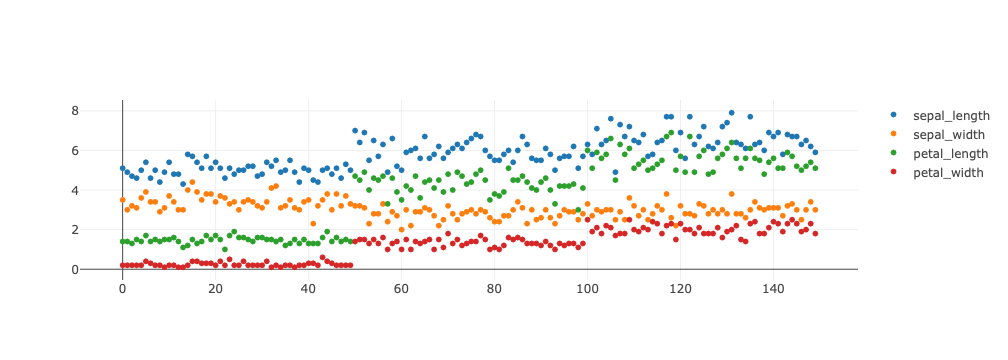

In [48]:
let x = Array::from_iter(0..150);

let mut plot = Plot::new();

let t1 = Scatter::from_array(x.clone(), f.slice(s![.., 0]).to_owned())
  .name("sepal_length")
  .mode(Mode::Markers);
let t2 = Scatter::from_array(x.clone(), f.slice(s![.., 1]).to_owned())
  .name("sepal_width")
  .mode(Mode::Markers);
let t3 = Scatter::from_array(x.clone(), f.slice(s![.., 2]).to_owned())
  .name("petal_length")
  .mode(Mode::Markers);

let t4 = Scatter::from_array(x.clone(), f.slice(s![.., 3]).to_owned())
  .name("petal_width")
  .mode(Mode::Markers);

plot.add_trace(t1);
plot.add_trace(t2);
plot.add_trace(t3);
plot.add_trace(t4);
plot

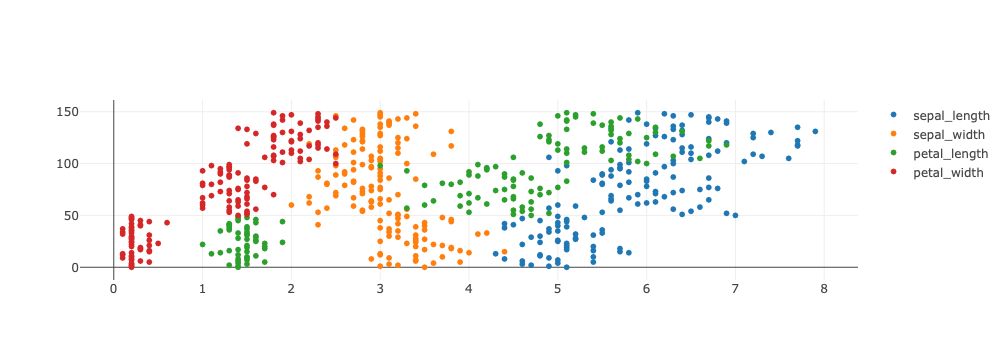

In [50]:
let x = Array::from_iter(0..150);

let mut plot = Plot::new();

let t1 = Scatter::from_array(f.slice(s![.., 0]).to_owned(), x.clone())
  .name("sepal_length")
  .mode(Mode::Markers);
let t2 = Scatter::from_array(f.slice(s![.., 1]).to_owned(), x.clone())
  .name("sepal_width")
  .mode(Mode::Markers);
let t3 = Scatter::from_array(f.slice(s![.., 2]).to_owned(), x.clone())
  .name("petal_length")
  .mode(Mode::Markers);

let t4 = Scatter::from_array(f.slice(s![.., 3]).to_owned(), x.clone())
  .name("petal_width")
  .mode(Mode::Markers);

plot.add_trace(t1);
plot.add_trace(t2);
plot.add_trace(t3);
plot.add_trace(t4);
plot

In [32]:
feature_df

shape: (150, 4)
┌──────────────┬─────────────┬──────────────┬─────────────┐
│ sepal_length ┆ sepal_width ┆ petal_length ┆ petal_width │
│ ---          ┆ ---         ┆ ---          ┆ ---         │
│ f64          ┆ f64         ┆ f64          ┆ f64         │
╞══════════════╪═════════════╪══════════════╪═════════════╡
│ 5.1          ┆ 3.5         ┆ 1.4          ┆ 0.2         │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 4.9          ┆ 3.0         ┆ 1.4          ┆ 0.2         │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 4.7          ┆ 3.2         ┆ 1.3          ┆ 0.2         │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 4.6          ┆ 3.1         ┆ 1.5          ┆ 0.2         │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ ...          ┆ ...         ┆ ...          ┆ ...         │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 6.3          ┆ 2.5         ┆ 5.0          ┆ 1.9         │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌

In [34]:
features.slice(s![.., 2])

[1.4, 1.4, 1.3, 1.5, 1.4, 1.7, 1.4, 1.5, 1.4, 1.5, 1.5, 1.6, 1.4, 1.1, 1.2, 1.5, 1.3, 1.4, 1.7, 1.5, 1.7, 1.5, 1.0, 1.7, 1.9, 1.6, 1.6, 1.5, 1.4, 1.6, 1.6, 1.5, 1.5, 1.4, 1.5, 1.2, 1.3, 1.5, 1.3, 1.5, 1.3, 1.3, 1.3, 1.6, 1.9, 1.4, 1.6, 1.4, 1.5, 1.4, 4.7, 4.5, 4.9, 4.0, 4.6, 4.5, 4.7, 3.3, 4.6, 3.9, 3.5, 4.2, 4.0, 4.7, 3.6, 4.4, 4.5, 4.1, 4.5, 3.9, 4.8, 4.0, 4.9, 4.7, 4.3, 4.4, 4.8, 5.0, 4.5, 3.5, 3.8, 3.7, 3.9, 5.1, 4.5, 4.5, 4.7, 4.4, 4.1, 4.0, 4.4, 4.6, 4.0, 3.3, 4.2, 4.2, 4.2, 4.3, 3.0, 4.1, 6.0, 5.1, 5.9, 5.6, 5.8, 6.6, 4.5, 6.3, 5.8, 6.1, 5.1, 5.3, 5.5, 5.0, 5.1, 5.3, 5.5, 6.7, 6.9, 5.0, 5.7, 4.9, 6.7, 4.9, 5.7, 6.0, 4.8, 4.9, 5.6, 5.8, 6.1, 6.4, 5.6, 5.1, 5.6, 6.1, 5.6, 5.5, 4.8, 5.4, 5.6, 5.1, 5.1, 5.9, 5.7, 5.2, 5.0, 5.2, 5.4, 5.1], shape=[150], strides=[1], layout=CFcf (0xf), const ndim=1

In [59]:
use plotly::ndarray::ArrayTraces;

let traces = Scatter::default()
  .mode(Mode::Markers)
  .to_traces(x.clone(), f.clone(), ArrayTraces::OverColumns);

let mut plot = Plot::new();
plot.add_traces(traces);
plot

Error: consider importing this trait

In [60]:
:explain

Error: Sorry, last error has no explanation

In [77]:
let n: usize = 11;
let t: Array<f64, Ix1> = Array::range(0., 10., 10. / n as f64);
let mut ys: Array<f64, Ix2> = Array::zeros((11, 11));
let mut count = 0.;
for mut row in ys.columns_mut() {
    for index in 0..row.len() {
        row[index] = count + (index as f64).powf(2.);
    }
    count += 1.;
}

let traces =
    Scatter::default()
        .mode(Mode::Markers);
        .to_traces(t, ys, ArrayTraces::OverColumns);

// let mut plot = Plot::new();
// plot.add_traces(traces);

Error: Couldn't automatically determine type of variable `traces`.
Please give it an explicit type.